# **Mineria de Datos - TD IDF**

#### *Nombre:* PEREIRA CHINCHERO Richard Mikhael
#### *Codigo:* 171916
#### *Proposito:* 
    1.- Implementar en un notebook pyspark usando mapreduce el algoritmo TF-IDF 

## **Librerias**

In [6]:
# Iniciarlizacion de PySpark
import findspark
findspark.init()

In [10]:
# Importacion de librerias principales
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.appName('TF IDF')\
    .config('spark.master', 'local[4]')\
    .config('spark.shuffle.sql.partitions', 1)\
    .sc = SparkContext.getOrCreate()

In [13]:
import pyspark # only run after findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [14]:
# Verificacion de la Importacion
spark

<SparkContext master=local[*] appName=pyspark-shell>

# **Datos de Prueba**

In [22]:
data=[(1,'i love dogs'),(2,"i hate dogs and knitting"),(3,"knitting is my hobby and my passion")]
lineas=sc.parallelize(data)
lineas.collect()

[(1, 'i love dogs'),
 (2, 'i hate dogs and knitting'),
 (3, 'knitting is my hobby and my passion')]

## Paso1:     
    Asignamos un valor o clave como ID. Usaremos la transforacion flatMap aqui para combinar todos los tokens en una sola lista   

    ('linea id', 'text') => (('linea id', 'token'), 1)

In [23]:
# Usamos la transformacion
map1=lineas.flatMap(lambda x: [((x[0],i),1) for i in x[1].split()])
map1.collect()

[((1, 'i'), 1),
 ((1, 'love'), 1),
 ((1, 'dogs'), 1),
 ((2, 'i'), 1),
 ((2, 'hate'), 1),
 ((2, 'dogs'), 1),
 ((2, 'and'), 1),
 ((2, 'knitting'), 1),
 ((3, 'knitting'), 1),
 ((3, 'is'), 1),
 ((3, 'my'), 1),
 ((3, 'hobby'), 1),
 ((3, 'and'), 1),
 ((3, 'my'), 1),
 ((3, 'passion'), 1)]

## Paso 2: 
    En este paso, agruparemos los pares clave / valor con la clave común y agregaremos los valores de la misma clave para obtener la frecuencia del término para una palabra en particular correspondiente a su ID de documento.  

    ('linea id', 'text') => (('linea id', 'token'), [1+1+1...])

In [24]:
reduce=map1.reduceByKey(lambda x,y:x+y)
reduce.collect()

[((2, 'i'), 1),
 ((2, 'dogs'), 1),
 ((3, 'passion'), 1),
 ((3, 'hobby'), 1),
 ((1, 'i'), 1),
 ((1, 'dogs'), 1),
 ((2, 'and'), 1),
 ((2, 'knitting'), 1),
 ((3, 'my'), 2),
 ((1, 'love'), 1),
 ((2, 'hate'), 1),
 ((3, 'knitting'), 1),
 ((3, 'and'), 1),
 ((3, 'is'), 1)]

## Paso 3: 
    En este paso, cambiaremos los pares clave / valor a un nuevo conjunto de clave / valor / pares con tokens como clave y su ID de documento y la frecuencia de término respectiva como valores. 

    (('linea id', 'token', TF) => ('token', ('linea id', TF))

In [37]:
tf=reduce.map(lambda x: (x[0][1],(x[0][0],x[1])))
tf.collect()

[('i', (2, 1)),
 ('dogs', (2, 1)),
 ('my', (3, 2)),
 ('love', (1, 1)),
 ('passion', (3, 1)),
 ('hate', (2, 1)),
 ('knitting', (3, 1)),
 ('hobby', (3, 1)),
 ('and', (3, 1)),
 ('i', (1, 1)),
 ('dogs', (1, 1)),
 ('and', (2, 1)),
 ('knitting', (2, 1)),
 ('is', (3, 1))]

# **Calculo de la frecuencia inversa de Documentos (IDF)**

    La puntuación IDF nos dice qué tan importante es una palabra en particular en todo el corpus. Por ejemplo, si aparece una palabra en cada documento, la puntuación de la FDI será cero para eso.

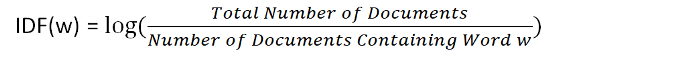

In [38]:
# Mapeo: a partir de identificador o id como clave del TF.
map3=reduce.map(lambda x: (x[0][1],(x[0][0],x[1],1))) #Aqui la clave sera el token y su valor sera el identificados
map3.collect()

[('i', (2, 1, 1)),
 ('dogs', (2, 1, 1)),
 ('my', (3, 2, 1)),
 ('love', (1, 1, 1)),
 ('passion', (3, 1, 1)),
 ('hate', (2, 1, 1)),
 ('knitting', (3, 1, 1)),
 ('hobby', (3, 1, 1)),
 ('and', (3, 1, 1)),
 ('i', (1, 1, 1)),
 ('dogs', (1, 1, 1)),
 ('and', (2, 1, 1)),
 ('knitting', (2, 1, 1)),
 ('is', (3, 1, 1))]

In [40]:
map4=map3.map(lambda x:(x[0],x[1][2])) # Aqui extraemos el token y el numero de contador de i como ocurrencia en ciertos documentos
map4.collect()

[('i', 1),
 ('dogs', 1),
 ('my', 1),
 ('love', 1),
 ('passion', 1),
 ('hate', 1),
 ('knitting', 1),
 ('hobby', 1),
 ('and', 1),
 ('i', 1),
 ('dogs', 1),
 ('and', 1),
 ('knitting', 1),
 ('is', 1)]

In [41]:
# Reducireduce2=map4.reduceByKey(lambda x,y:x+y)
reduce2=map4.reduceByKey(lambda x,y:x+y)
reduce2.collect()

[('i', 2),
 ('dogs', 2),
 ('passion', 1),
 ('knitting', 2),
 ('hobby', 1),
 ('and', 2),
 ('love', 1),
 ('hate', 1),
 ('is', 1),
 ('my', 1)]

In [42]:
import math

from pyspark.sql.functions import *

idf=reduce2.map(lambda x: (x[0],math.log10(len(data)/x[1])))
idf.collect()

[('i', 0.17609125905568124),
 ('dogs', 0.17609125905568124),
 ('passion', 0.47712125471966244),
 ('knitting', 0.17609125905568124),
 ('hobby', 0.47712125471966244),
 ('and', 0.17609125905568124),
 ('love', 0.47712125471966244),
 ('hate', 0.47712125471966244),
 ('is', 0.47712125471966244),
 ('my', 0.47712125471966244)]

# **Computacion TD-IDF**
    Ahora tenemos dos RDD, uno con la identificación del documento junto con la frecuencia del término del documento para cada token. Otro RDD que tiene puntuaciones IDF para cada token. 

    Para obtener el TF con el IDF realizaremos una combinacioninterna para signar a cada token una identificacion de documento.

In [43]:
rdd=tf.join(idf)
rdd.collect()

[('i', ((2, 1), 0.17609125905568124)),
 ('i', ((1, 1), 0.17609125905568124)),
 ('dogs', ((2, 1), 0.17609125905568124)),
 ('dogs', ((1, 1), 0.17609125905568124)),
 ('passion', ((3, 1), 0.47712125471966244)),
 ('hobby', ((3, 1), 0.47712125471966244)),
 ('hate', ((2, 1), 0.47712125471966244)),
 ('my', ((3, 2), 0.47712125471966244)),
 ('knitting', ((3, 1), 0.17609125905568124)),
 ('knitting', ((2, 1), 0.17609125905568124)),
 ('and', ((3, 1), 0.17609125905568124)),
 ('and', ((2, 1), 0.17609125905568124)),
 ('love', ((1, 1), 0.47712125471966244)),
 ('is', ((3, 1), 0.47712125471966244))]

In [44]:
rdd=rdd.map(lambda x: (x[1][0][0],(x[0],x[1][0][1],x[1][1],x[1][0][1]*x[1][1]))).sortByKey()
rdd.collect()

[(1, ('i', 1, 0.17609125905568124, 0.17609125905568124)),
 (1, ('dogs', 1, 0.17609125905568124, 0.17609125905568124)),
 (1, ('love', 1, 0.47712125471966244, 0.47712125471966244)),
 (2, ('i', 1, 0.17609125905568124, 0.17609125905568124)),
 (2, ('dogs', 1, 0.17609125905568124, 0.17609125905568124)),
 (2, ('hate', 1, 0.47712125471966244, 0.47712125471966244)),
 (2, ('knitting', 1, 0.17609125905568124, 0.17609125905568124)),
 (2, ('and', 1, 0.17609125905568124, 0.17609125905568124)),
 (3, ('passion', 1, 0.47712125471966244, 0.47712125471966244)),
 (3, ('hobby', 1, 0.47712125471966244, 0.47712125471966244)),
 (3, ('my', 2, 0.47712125471966244, 0.9542425094393249)),
 (3, ('knitting', 1, 0.17609125905568124, 0.17609125905568124)),
 (3, ('and', 1, 0.17609125905568124, 0.17609125905568124)),
 (3, ('is', 1, 0.47712125471966244, 0.47712125471966244))]

In [45]:
# Mostrar el TD-IDF
rdd=rdd.map(lambda x: (x[0],x[1][0],x[1][1],x[1][2],x[1][3]))
rdd.toDF(["DocumentId","Token","TF","IDF","TF-IDF"]).show()

+----------+--------+---+-------------------+-------------------+
|DocumentId|   Token| TF|                IDF|             TF-IDF|
+----------+--------+---+-------------------+-------------------+
|         1|       i|  1|0.17609125905568124|0.17609125905568124|
|         1|    dogs|  1|0.17609125905568124|0.17609125905568124|
|         1|    love|  1|0.47712125471966244|0.47712125471966244|
|         2|       i|  1|0.17609125905568124|0.17609125905568124|
|         2|    dogs|  1|0.17609125905568124|0.17609125905568124|
|         2|    hate|  1|0.47712125471966244|0.47712125471966244|
|         2|knitting|  1|0.17609125905568124|0.17609125905568124|
|         2|     and|  1|0.17609125905568124|0.17609125905568124|
|         3| passion|  1|0.47712125471966244|0.47712125471966244|
|         3|   hobby|  1|0.47712125471966244|0.47712125471966244|
|         3|      my|  2|0.47712125471966244| 0.9542425094393249|
|         3|knitting|  1|0.17609125905568124|0.17609125905568124|
|         